# DATAIKU CHALLENGE
author: Khalil CHOUROU

The first step is to load data and add header to Dataframe since it is missing from the train set. I was based on census_income_metadata.txt file to do this step.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn import tree
from sklearn.externals.six import StringIO  
from sklearn import linear_model,cross_validation

data = pd.read_csv('census_income_learn.csv', sep=',')
data.columns = ['age', 'class_of_worker','industry_code','occupation_code','education',
                'wage_per_hour','enrolled_in_edu_inst_last_wk','marital_status','major_industry_code',
               'major_occupation_code','race','hispanic_Origin','sex','member_of_a_labor_union','reason_for_unemployment',
               'full_or_part_time_employment_stat','capital_gains','capital_losses','divdends_from_stocks',
               'tax_filer_status','region_of_previous_residence','state_of_previous_residence','detailed_household_and_family_stat',
               'detailed_household_summary_in_household','instances_weight','migration_code_change_in_msa',
               'migration_code_change_in_reg','migration_code_move_within_reg','live_in_this_house_1_year_ago',
               'migration_prev_res_in_sunbelt','num_persons_worked_for_employer','family_members_under_18',
               'country_of_birth_father','country_of_birth_mother','country_of_birth_self','citizenship','own_business_or_self_employed',
                'fill_inc_questionnaire_for_veterans','veterans_benefit',
               'weeks_worked_in_year','year','income']
data.head()                                   
    

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans,veterans_benefit,weeks_worked_in_year,year,income
0,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
1,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
2,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
3,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,- 50000.


<strong>Data cleaning</strong>

At this point, we will study the purity of our data by identifiying missing values per column. "Not in universe" refers
to "nan" which is the empty value recognized by default by pandas. Hence, we will replace "Not in universe" by "nan" value then we evaluate the emptyness percentage per column

In [226]:
data.replace('[ ]*Not in universe',np.nan, inplace=True,regex=True)   # replace not in universe with nan in order to drop rows containing 
print data.count(0)/data.shape[0]


age                                        1.000000
class_of_worker                            0.497579
industry_code                              1.000000
occupation_code                            1.000000
education                                  1.000000
wage_per_hour                              1.000000
enrolled_in_edu_inst_last_wk               0.063051
marital_status                             1.000000
major_industry_code                        0.495379
major_occupation_code                      0.495379
race                                       1.000000
hispanic_Origin                            1.000000
sex                                        1.000000
member_of_a_labor_union                    0.095548
reason_for_unemployment                    0.030423
full_or_part_time_employment_stat          1.000000
capital_gains                              1.000000
capital_losses                             1.000000
divdends_from_stocks                       1.000000
tax_filer_st

Columns containig empty values lower than 90% will be discarded from our study since they do not bring relevant information. In fact by including "Not in universe" we would consider that value as a feature by itself while in reality it mapps to different features of a given column (for example not in universe for column region of previous residence could be New York for some observations and Georgia for others). This would lead to error while performing the learning since we would attach same coefficient to observations sharing the feature "Not in universe" while in reality they should not.

The last column income is the target that we want to predict. According to the given problem, we want to predict if a citizen would earn more or less than 50K$. This is a classification problem so we would replace 5000+ by 1 and 5000- by -1.

<strong> Columns description </strong>

In [2]:
data = data[['age','industry_code','occupation_code','education',
               'wage_per_hour','marital_status',
               'race','hispanic_Origin','sex',
               'full_or_part_time_employment_stat','capital_gains','capital_losses','divdends_from_stocks',
               'tax_filer_status','detailed_household_and_family_stat',
               'detailed_household_summary_in_household','instances_weight','migration_code_change_in_msa',
               'migration_code_change_in_reg','migration_code_move_within_reg',
               'num_persons_worked_for_employer',
               'country_of_birth_father','country_of_birth_mother','country_of_birth_self','citizenship','own_business_or_self_employed',
               'veterans_benefit','weeks_worked_in_year','year','income']]
data = data.dropna()  # remove empty rows
data['income'].replace('[ ]*-[ ]*50000.',0,regex=True,inplace=True) # replace 
data['income'].replace('[ ]*50000\+.',1,regex=True,inplace=True)

data.describe()

,age,industry_code,occupation_code,wage_per_hour,capital_gains,capital_losses,divdends_from_stocks,instances_weight,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefit,weeks_worked_in_year,year,income
count,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000
mean,34.494006,15.352397,11.306613,55.427186,434.721169,37.313975,197.530523,1740.380471,1.956190,0.175439,1.514830,23.175013,94.499669,0.062058
std,22.310785,18.067141,14.454218,274.897115,4697.542951,271.897097,1984.168581,993.770642,2.365127,0.553696,0.851475,24.411494,0.500001,0.241262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000,0.000000
25%,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1061.607500,0.000000,0.000000,2.000000,0.000000,94.000000,0.000000
50%,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000,0.000000
75%,50.000000,33.000000,26.000000,0.000000,0.000000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000,0.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.000000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000,1.000000



<strong> Making better sense of features </strong>

Once data is clean, the next step is to select the right features (columns in this case) that contribute to make descrimination between the two studied classes. To get better sense of this information, we will make graphics and chart
that give us further information about the correlation between features and income (target value)

#####Age
First, we will start by studying income in function of age:

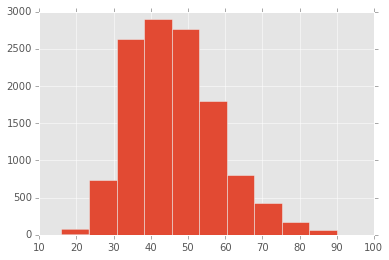

In [3]:
# income distribution higher than 50K$ in function of age 
data['age'][data['income']==1].hist()

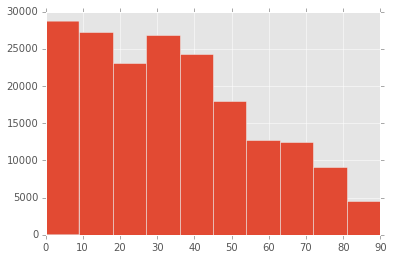

In [4]:
# income distribution less than 50K$ in function of age 
data['age'][data['income']==0].hist()

Adult people (between 30 and 50) is the category that perceives highest wages compared to the rest of population while young generation get the lowest wages. We can conclude that age is criteria of descrimination between salaries. 

#####Education
The next feature to study is diploma. By intuition, we expect that people with higher diploma would get higher salaries. Let's reveal what data hides 

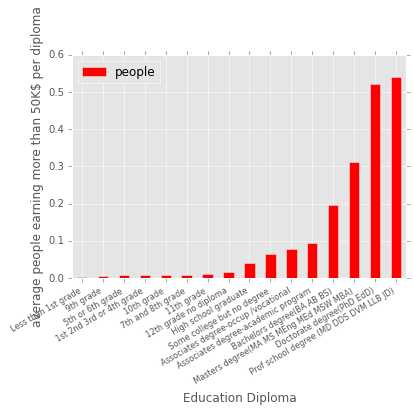

In [5]:
# income distribution in function of diploma
education_level_income_high = data[data['income']==1].groupby(['education']).count()
education_level_income_high = education_level_income_high[['income']]
education_level_income_high.columns = ['people']
education_level_income_high.head()


education_aggregation = data.groupby(['education']).count()
education_aggregation = education_aggregation[['income']]
education_aggregation.columns = ['people']
education_aggregation.head()
education_level_income_high.people = education_level_income_high.people / education_aggregation.people
education_level_income_high = education_level_income_high[['people']].sort('people')
ax = education_level_income_high.plot(kind = 'bar', color = 'r')
ax.set_xticklabels(education_level_income_high.index, rotation=30, fontsize=8, ha='right')
ax.set_xlabel('Education Diploma')
ax.set_ylabel('average people earning more than 50K$ per diploma')

Indeed, the more people have higher degrees the better they are paid 

####Working hours
Analysis of salary in function of working hours

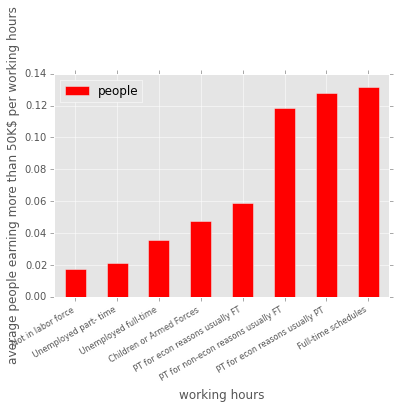

In [7]:

time_level_income_high = data[data['income']==1].groupby(['full_or_part_time_employment_stat']).count()
time_level_income_high = time_level_income_high[['income']]
time_level_income_high.columns = ['people']

time_aggregation = data.groupby(['full_or_part_time_employment_stat']).count()
time_aggregation = time_aggregation[['income']]
time_aggregation.columns = ['people']
time_level_income_high.people = time_level_income_high.people / time_aggregation.people
time_level_income_high = time_level_income_high[['people']].sort('people')
ax = time_level_income_high.plot(kind = 'bar', color = 'r')
ax.set_xticklabels(time_level_income_high.index, rotation=30, fontsize=8, ha='right')
ax.set_xlabel('working hours')
ax.set_ylabel('average people earning more than 50K$ per working hours')

From the chart above, we conclude that people who work more hours earn more.

####Gender
Ananlysis of income in function of gender

0.0256099554735
0.0256099554735


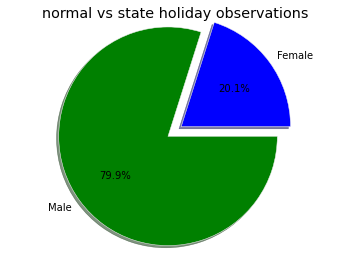

In [8]:
# repartition of income higher than 50K$ between male and female
income_high_by_gender = data[data['income']==1].groupby(['sex']).size()
aggregated_gender = data.groupby(['sex']).size()
income_high_by_gender = income_high_by_gender/aggregated_gender
name = ['Female','Male']
frac_man = income_high_by_gender.values[0]/(income_high_by_gender.values[0]+income_high_by_gender.values[1])
frac_wome = income_high_by_gender.values[1]/(income_high_by_gender.values[0]+income_high_by_gender.values[1])
data_plot = [frac_man,frac_wome]

explode=(0.15, 0)
plt.pie(data_plot, explode=explode, labels=name, autopct='%1.1f%%', startangle=0, shadow=True)
plt.axis('equal')
plt.title('normal vs state holiday observations')
plt.show()

The pie chart illustrates that men earn more than women


####Features selection:

In [9]:
data = data[['age','industry_code','education','marital_status','occupation_code','race','sex','wage_per_hour','country_of_birth_self','citizenship','full_or_part_time_employment_stat','income']]

Read test data and extract features

In [10]:
data_test = pd.read_csv('census_income_test.csv')
data_test.columns = ['age', 'class_of_worker','industry_code','occupation_code','education',
                'wage_per_hour','enrolled_in_edu_inst_last_wk','marital_status','major_industry_code',
               'major_occupation_code','race','hispanic_Origin','sex','member_of_a_labor_union','reason_for_unemployment',
               'full_or_part_time_employment_stat','capital_gains','capital_losses','divdends_from_stocks',
               'tax_filer_status','region_of_previous_residence','state_of_previous_residence','detailed_household_and_family_stat',
               'detailed_household_summary_in_household','instances_weight','migration_code_change_in_msa',
               'migration_code_change_in_reg','migration_code_move_within_reg','live_in_this_house_1_year_ago',
               'migration_prev_res_in_sunbelt','num_persons_worked_for_employer','family_members_under_18',
               'country_of_birth_father','country_of_birth_mother','country_of_birth_self','citizenship','own_business_or_self_employed',
                'fill_inc_questionnaire_for_veterans','veterans_benefit',
               'weeks_worked_in_year','year','income']

data_test = data_test[['age','industry_code','occupation_code','education',
               'wage_per_hour','marital_status',
               'race','hispanic_Origin','sex',
               'full_or_part_time_employment_stat','capital_gains','capital_losses','divdends_from_stocks',
               'tax_filer_status','detailed_household_and_family_stat',
               'detailed_household_summary_in_household','instances_weight','migration_code_change_in_msa',
               'migration_code_change_in_reg','migration_code_move_within_reg',
               'num_persons_worked_for_employer',
               'country_of_birth_father','country_of_birth_mother','country_of_birth_self','citizenship','own_business_or_self_employed',
               'veterans_benefit','weeks_worked_in_year','year','income']]
data_test.replace('[ ]*Not in universe',np.nan, inplace=True,regex=True)

data_test = data_test.dropna()
data_test['income'].replace('[ ]*-[ ]*50000.',0,regex=True,inplace=True)
data_test['income'].replace('[ ]*50000\+.',1,regex=True,inplace=True)

data_test.head()
#data_test = data_test.dropna(how='any')

,age,industry_code,occupation_code,education,wage_per_hour,marital_status,race,hispanic_Origin,sex,full_or_part_time_employment_stat,...,num_persons_worked_for_employer,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,veterans_benefit,weeks_worked_in_year,year,income
0,44,37,12,Associates degree-occup /vocational,0,Married-civilian spouse present,White,All other,Female,PT for econ reasons usually PT,...,1,United-States,United-States,United-States,Native- Born in the United States,0,2,26,95,0
1,2,0,0,Children,0,Never married,White,Mexican-American,Male,Children or Armed Forces,...,0,United-States,United-States,United-States,Native- Born in the United States,0,0,0,95,0
2,35,29,3,High school graduate,0,Divorced,White,All other,Female,Children or Armed Forces,...,5,United-States,United-States,United-States,Native- Born in the United States,2,2,52,94,0
3,49,4,34,High school graduate,0,Divorced,White,All other,Male,Full-time schedules,...,4,United-States,United-States,United-States,Native- Born in the United States,0,2,50,95,0
4,13,0,0,Children,0,Never married,White,All other,Male,Children or Armed Forces,...,0,Germany,United-States,United-States,Native- Born in the United States,0,0,0,94,0


In [11]:
data_test = data_test[['age','industry_code','education','marital_status','occupation_code','race','sex','wage_per_hour','country_of_birth_self','citizenship','full_or_part_time_employment_stat','income']]          
formula = 'income ~  age + industry_code + education + marital_status + occupation_code + race + sex + wage_per_hour + country_of_birth_self+citizenship+full_or_part_time_employment_stat ' 
y_train,x_train = dmatrices(formula, data=data, return_type='dataframe')
y_test,x_test = dmatrices(formula, data=data_test, return_type='dataframe')



##Model

<strong>Logistic regression</strong>

In [16]:
# logistic regression
from sklearn.metrics import classification_report
logreg = linear_model.LogisticRegression()
logreg = logreg.fit(x_train, y_train.income)

y_pred = logreg.predict(x_test)

print pd.crosstab(y_test.income
                  ,y_pred
                  ,rownames = ['Actual']
                  ,colnames = ['Predicted'])

print classification_report(y_test.income,y_pred)

Predicted      0     1
Actual                
0          92013   839
1           4909  1277
             precision    recall  f1-score   support

        0.0       0.95      0.99      0.97     92852
        1.0       0.60      0.21      0.31      6186

avg / total       0.93      0.94      0.93     99038



Precision is the fraction of retrieved instances that are relevant, while recall is the fraction of relevant instances that are retrieved. The precision of predicting for class 0 zero is higher than class 1 (0.95 vs 0.6). The recall is also  higher for the first class. This lead in the end to prediction rate of 93% on the test set

<strong>Decesion Trees</strong>

In [17]:


clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print pd.crosstab(y_test.income
                  ,y_pred
                  ,rownames = ['Actual']
                  ,colnames = ['Predicted'])

print '\n \n'

print classification_report(y_test.income,y_pred)

Predicted      0     1
Actual                
0          89301  3551
1           3901  2285

 

             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96     92852
        1.0       0.39      0.37      0.38      6186

avg / total       0.92      0.92      0.92     99038



With decision trees, performance decreased compared to logistic regression since the overall prediction error decreased by 1% (92%)

<strong>Random Forest</strong>

In [18]:
# Random Forest

import sklearn.ensemble as sk

clf = sk.RandomForestClassifier(n_estimators=100, oob_score=True,min_samples_split=5, min_samples_leaf= 2)
clf = clf.fit(x_train, y_train.income)

In [19]:
y_pred = clf.predict(x_test)

print pd.crosstab(y_test.income
                  ,y_pred
                  ,rownames = ['Actual']
                  ,colnames = ['Predicted'])

print '\n \n'

print classification_report(y_test.income,y_pred)

Predicted      0     1
Actual                
0          92069   783
1           4474  1712

 

             precision    recall  f1-score   support

        0.0       0.95      0.99      0.97     92852
        1.0       0.69      0.28      0.39      6186

avg / total       0.94      0.95      0.94     99038



The random forest perfoms better thant Decesion Trees and Logistic regression by increasing the prediction accuracy to 94% (for precision) and 95% (for recall). In the same time, computation time increased using random forest.

####Challenges
The main challenging parts are:
- understanding the data: getting sense of the values per each column and the correlation between target and features.
- Tunning model hyperparameters is also important because it requires a statiscal and mathematical knolwedge besides to computer science technicity (sklearn packages and python libraries).
